<a href="https://colab.research.google.com/github/Nazdi68/Agente-1-de-pron-sticos/blob/main/AgentePronosticos_ConJustificacion_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 0: Imports y funciones generales
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from google.colab import files
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression

def detect_trend(y, threshold=0.01):
    t = np.arange(len(y))
    coef = np.polyfit(t, y, 1)[0]
    return abs(coef) > threshold

def detect_seasonality(y, freq=12, thresh=0.01):
    dec = seasonal_decompose(y, model='additive', period=freq,
                             two_sided=False, extrapolate_trend='freq')
    return dec.seasonal.std() > thresh

def detect_stationarity(y, alpha=0.05):
    pval = adfuller(y)[1]
    return pval < alpha

In [ ]:
# Cell 1: Carga directa del dataset de ejemplo
dates = pd.date_range('2022-01-01', periods=24, freq='M')
sales = [200 + i*10 + 5*(-1)**i for i in range(24)]
df = pd.DataFrame({'Fecha': dates, 'Ventas': sales})
df['Fecha'] = pd.to_datetime(df['Fecha'])
print('✔ Dataset de ejemplo cargado')
df.head()

✔ Dataset de ejemplo cargado


<ipython-input-2-2e17d6c9c451>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range('2022-01-01', periods=24, freq='M')


,Fecha,Ventas
0,2022-01-31,205
1,2022-02-28,205
2,2022-03-31,225
3,2022-04-30,225
4,2022-05-31,245


In [ ]:
# Cell 2: Diagnóstico automático y justificación detallada
y = df['Ventas'].values
# Detección de tendencia
trend = detect_trend(y)
# Detección de estacionalidad
season = detect_seasonality(y)
# Cálculo de coeficiente y desviación estacional
t = np.arange(len(y))
coef = np.polyfit(t, y, 1)[0]
dec = seasonal_decompose(y, model='additive', period=12,
                          two_sided=False, extrapolate_trend='freq')
season_std = dec.seasonal.std()

print(f"Tendencia: {trend} (coeficiente = {coef:.4f}), Estacionalidad: {season} (std = {season_std:.4f})")

if not trend and not season:
    suggestion = 'Simple'
elif trend and not season:
    suggestion = 'Holt'
elif season and not trend:
    suggestion = 'HW Aditivo'
else:
    suggestion = 'HW Multiplicativo'

print(f"✅ Modelo sugerido: {suggestion}")

Tendencia: True (coeficiente = 9.9478), Estacionalidad: True (std = 5.0000)
✅ Modelo sugerido: HW Multiplicativo


In [ ]:
# Cell 3: Selección manual de modelo
models = [
    'Simple', 'Holt', 'HW Aditivo', 'HW Multiplicativo',
    'ARIMA', 'Regresión Lineal Simple', 'Regresión Lineal Múltiple'
]
print('Modelos disponibles:')
for i, m in enumerate(models, 1): print(f'  {i}. {m}')
choice = input('Elige un modelo (1–7) o ENTER para sugerido: ')
model_name = suggestion
if choice.isdigit() and 1 <= int(choice) <= len(models):
    model_name = models[int(choice)-1]
print(f"🔄 Modelo seleccionado: {model_name}")

Modelos disponibles:
  1. Simple
  2. Holt
  3. HW Aditivo
  4. HW Multiplicativo
  5. ARIMA
  6. Regresión Lineal Simple
  7. Regresión Lineal Múltiple
Elige un modelo (1–7) o ENTER para sugerido: 
🔄 Modelo seleccionado: HW Multiplicativo


In [ ]:
# Cell 4: Horizonte y pronóstico unificado con todos los métodos
n = len(y)
limits = {
    'Simple': int(n*0.25), 'Holt': int(n*0.5),
    'HW Aditivo': 24, 'HW Multiplicativo': 12,
    'ARIMA': n,
    'Regresión Lineal Simple': n,
    'Regresión Lineal Múltiple': n
}
hmax = limits[model_name]
print(f"🔢 Horizonte máximo recomendado para '{model_name}': {hmax} meses")
h = int(input(f"¿Cuántos meses deseas pronosticar? (1–{hmax}): "))

if model_name == 'ARIMA':
    order=(1,1,1); seasonal=(1,1,1,12) if season else (0,0,0,0)
    model=SARIMAX(y, order=order, seasonal_order=seasonal,
                  enforce_stationarity=False, enforce_invertibility=False)
    fit=model.fit(disp=False)
    pred=fit.get_forecast(steps=h).predicted_mean

elif model_name == 'Regresión Lineal Simple':
    t = np.arange(n).reshape(-1,1)
    lr = LinearRegression(); lr.fit(t,y)
    future_t = np.arange(n, n+h).reshape(-1,1)
    pred = lr.predict(future_t)

elif model_name == 'Regresión Lineal Múltiple':
    exog = df.drop(columns=['Fecha','Ventas']).astype(float)
    lr = LinearRegression(); lr.fit(exog, y)
    last = exog.iloc[-1].values.reshape(1,-1)
    Xf = np.repeat(last, h, axis=0)
    pred = lr.predict(Xf)

else:
    params={}
    if model_name=='Holt': params['trend']='add'
    if model_name=='HW Aditivo': params.update({'seasonal':'add','seasonal_periods':12})
    if model_name=='HW Multiplicativo': params.update({'trend':'add','seasonal':'mul','seasonal_periods':12})
    model=ExponentialSmoothing(y, **params)
    fit=model.fit(); pred=fit.forecast(h)

future=[df['Fecha'].iloc[-1] + timedelta(days=30*(i+1)) for i in range(h)]
fc=pd.DataFrame({'Fecha':future,'Pronóstico':pred})
fc

🔢 Horizonte máximo recomendado para 'HW Multiplicativo': 12 meses
¿Cuántos meses deseas pronosticar? (1–12): 12


,Fecha,Pronóstico
0,2024-01-30,447.888193
1,2024-02-29,441.921934
2,2024-03-30,467.716428
3,2024-04-29,462.099949
4,2024-05-29,487.562904
5,2024-06-28,482.260161
6,2024-07-28,507.424837
7,2024-08-27,502.404098
8,2024-09-26,527.300139
9,2024-10-26,522.534665


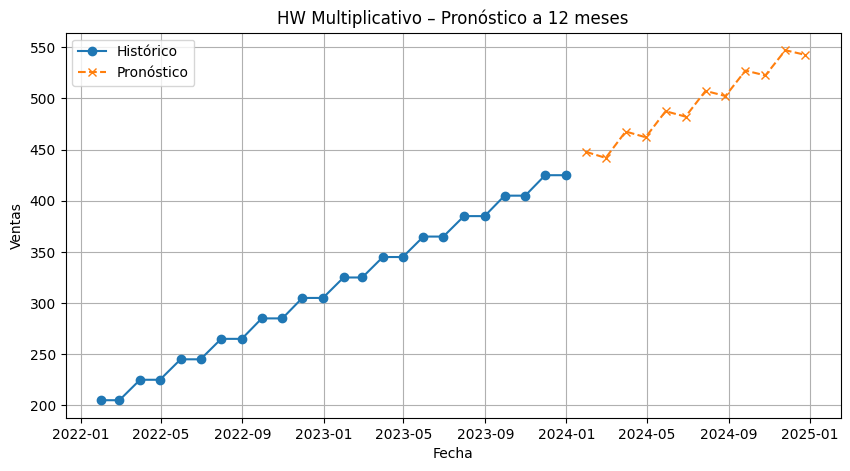

In [ ]:
# Cell 5: Visualización
plt.figure(figsize=(10,5))
plt.plot(df['Fecha'], df['Ventas'], 'o-', label='Histórico')
plt.plot(future, pred, 'x--', label='Pronóstico')
plt.title(f"{model_name} – Pronóstico a {h} meses")
plt.xlabel('Fecha'); plt.ylabel('Ventas'); plt.legend(); plt.grid(True)
plt.show()

In [ ]:
# Cell 6: Recomendaciones
diff=pred.mean()-df['Ventas'].tail(h).mean()
print('🔔 Tendencia al alza: considera aumentar inventario.') if diff>0 else print('🔔 Tendencia a la baja: optimiza recursos.')

🔔 Tendencia al alza: considera aumentar inventario.


In [ ]:
!pip install --quiet xlsxwriter

In [ ]:
# Cell 7: Exportar todo en una sola hoja “Pronóstico”
from google.colab import files

excel_file = 'pronostico_unificado.xlsx'
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # 1️⃣ Escribir la tabla
    fc.to_excel(writer, sheet_name='Pronóstico', index=False, startrow=0)
    workbook  = writer.book
    ws        = writer.sheets['Pronóstico']

    # 2️⃣ Gráfico nativo de Excel
    chart = workbook.add_chart({'type': 'line'})
    max_row = len(fc)
    chart.add_series({
        'name':       'Pronóstico',
        'categories': ['Pronóstico', 1, 0, max_row, 0],
        'values':     ['Pronóstico', 1, 1, max_row, 1],
        'marker':     {'type': 'circle', 'size': 4},
    })
    chart.set_title ({'name': f'Pronóstico ({model_name}) a {h} meses'})
    chart.set_x_axis({'name': 'Fecha'})
    chart.set_y_axis({'name': 'Ventas'})
    chart.set_legend({'position': 'bottom'})
    ws.insert_chart('D2', chart, {'x_scale': 1.2, 'y_scale': 1.2})

    # 3️⃣ Escribir la explicación justo debajo de la tabla
    start = max_row + 3  # dos filas en blanco después del último dato
    texto = [
        f"Informe: Agente de Pronósticos – Nazdi IA",
        f"Fecha de ejecución: {pd.Timestamp.now()}",
        f"Modelo elegido: {model_name}",
        f"Horizonte (meses): {h}",
        "",
        "🔔 Recomendaciones:",
        "• Tendencia al alza → considera aumentar inventario o expandir recursos.",
        "• Tendencia a la baja → optimiza recursos o revisa costos."
    ]
    for i, linea in enumerate(texto):
        ws.write(start + i, 0, linea)

# 4️⃣ Descargar el archivo
files.download(excel_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>